In [1]:
import sys
import ctypes
import ctypes.util
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 

try:
        libcudnn=ctypes.cdll.LoadLibrary('/usr/local/cuda-8.0/targets/x86_64-linux/lib/libcudnn.so.5.1.10')
except OSError:
        print("OSError");
print(libcudnn.cudnnGetVersion())
libcudnn.cudnnGetErrorString.restype = ctypes.c_char_p
libcudnn.cudnnGetErrorString.argtypes = [ctypes.c_int]

def cudnnCheckStatus(status):
    print(libcudnn.cudnnGetErrorString(status))

#**********Defining Handle***************
handle=ctypes.c_void_p()
print("Handle Creation Status:")
cudnnCheckStatus(libcudnn.cudnnCreate(ctypes.byref(handle)))

5110
Handle Creation Status:
CUDNN_STATUS_SUCCESS


In [2]:
dir(libcudnn)

['_FuncPtr',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_func_flags_',
 '_func_restype_',
 '_handle',
 '_name',
 'cudnnCreate',
 'cudnnGetErrorString',
 'cudnnGetVersion']

(28, 28)


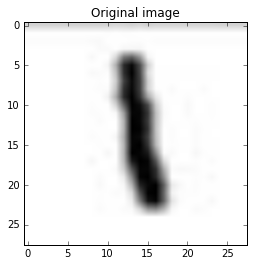

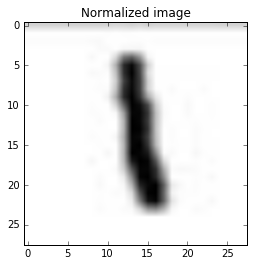

In [3]:
def normalize(image_data):
    a = 0.1; b = 0.9; MIN = 0; MAX = 255
    b=a + (((image_data - MIN)*(b - a))/(MAX - MIN))
    return b

img = cv2.imread('One.jpg',0)

print(img.shape)

plt.title("Original image")
plt.imshow(img,cmap='gray')
plt.show()

img=np.asarray(img)
img = normalize(img)

plt.title("Normalized image")
plt.imshow(img,cmap='gray')
plt.show()

In [4]:
#**********Defining Enumerated Types*************
"""
cudnnDataType={'CUDNN_DATA_FLOAT':0,'CUDNN_DATA_DOUBLE': 1}
cudnnTensorFormat = {'CUDNN_TENSOR_NCHW': 0}
cudnnConvolutionMode = {'CUDNN_CONVOLUTION': 0}
cudnnConvolutionFwdAlgo = {'CUDNN_CONVOLUTION_FWD_ALGO_GEMM':0}
cudnnConvolutionFwdPreference = {'CUDNN_CONVOLUTION_FWD_NO_WORKSPACE':0}

tensor_format = cudnnTensorFormat['CUDNN_TENSOR_NCHW']
data_type = cudnnDataType['CUDNN_DATA_DOUBLE']
convolution_mode = cudnnConvolutionMode['CUDNN_CONVOLUTION']
preference=cudnnConvolutionFwdPreference['CUDNN_CONVOLUTION_FWD_NO_WORKSPACE']
#algo=cudnnConvolutionFwdAlgo['CUDNN_CONVOLUTION_FWD_ALGO_GEMM']
"""
tensor_format=0
data_type=1
convolution_mode=0
algo=0
preference=0


In [5]:
#**********Dimensions************
n_i=1
c_i=1
h_i=28
w_i=28
h_k=2
w_k=2
k=1
pad_h=0
pad_w=0
stride_h=1
stride_w=1
upscalex=1
upscaley=1


#********GPU arrays***********

array_type=np.float64
#x=np.array([[[[1.0,2.0,3.0,4.0],[5.0,6.0,7.0,8.0],[9.0,10.0,11.0,12.0],[13.0,14.0,15.0,16.0],]]],dtype=array_type)
#x=np.random.rand(1,1,28,28)
x=img.reshape((n_i,c_i,h_i,w_i))
X=gpuarray.to_gpu(x)
w=np.array([[[1.0,0.0],[0.0,0.0]]],dtype=array_type)
W=gpuarray.to_gpu(w)

In [6]:
#*******Creating descriptors********
input_desc = ctypes.c_void_p()
print("Input Tensor Descriptor:")
cudnnCheckStatus(libcudnn.cudnnCreateTensorDescriptor(ctypes.byref(input_desc)))
output_desc = ctypes.c_void_p()
print("Output Tensor Descriptor:")
cudnnCheckStatus(libcudnn.cudnnCreateTensorDescriptor(ctypes.byref(output_desc)))
filter_desc = ctypes.c_void_p()
print("Filter Descriptor:")
cudnnCheckStatus(libcudnn.cudnnCreateFilterDescriptor(ctypes.byref(filter_desc)))
conv_desc = ctypes.c_void_p()
print("Convolution Descriptor")
cudnnCheckStatus(libcudnn.cudnnCreateConvolutionDescriptor(ctypes.byref(conv_desc)))

#********Set descriptors*******
print("Setting Input Descriptor:")
cudnnCheckStatus(libcudnn.cudnnSetTensor4dDescriptor(input_desc,tensor_format,data_type, n_i, c_i, h_i, w_i))
print("Setting Filter Descriptor:")
cudnnCheckStatus(libcudnn.cudnnSetFilter4dDescriptor(filter_desc,data_type,tensor_format,k,c_i,h_k,w_k));
print("Setting Convolution Desriptor:")
cudnnCheckStatus(libcudnn.cudnnSetConvolution2dDescriptor(conv_desc,pad_h,pad_w,stride_h,stride_w,upscalex,upscaley,convolution_mode));
        

#*********configuring the Output*********
print("Getting Output Dimensions:")
temp_n_o = ctypes.c_int()
temp_c_o = ctypes.c_int()
temp_h_o = ctypes.c_int()
temp_w_o = ctypes.c_int()
cudnnCheckStatus(libcudnn.cudnnGetConvolution2dForwardOutputDim(conv_desc, input_desc,filter_desc, ctypes.byref(temp_n_o),ctypes.byref(temp_c_o), ctypes.byref(temp_h_o),ctypes.byref(temp_w_o)))

n_o=temp_n_o.value
c_o=temp_c_o.value
w_o=temp_w_o.value
h_o=temp_h_o.value
print("Output Dimensions: ",n_o,c_o,h_o,w_o)
Y = gpuarray.empty((n_o,c_o,h_o,w_o), array_type)
print("Setting Output Descriptor:")
cudnnCheckStatus(libcudnn.cudnnSetTensor4dDescriptor(output_desc,tensor_format,data_type,n_o,c_o,h_o,w_o));

#*********Setting Workspace********
algo=ctypes.c_int()
memory_limit=ctypes.c_size_t(1024*1024)
cudnnCheckStatus(libcudnn.cudnnGetConvolutionForwardAlgorithm(handle,input_desc,filter_desc,conv_desc,output_desc,preference,memory_limit,ctypes.byref(algo)))


"""
libcudnn.cudnnGetConvolutionForwardWorkspaceSize.restype=int
libcudnn.cudnnGetConvolutionForwardWorkspaceSize.argtypes=[ctypes.c_void_p,ctypes.c_void_p,ctypes.c_void_p,ctypes.c_void_p,ctypes.c_void_p,ctypes.c_int,ctypes.c_void_p]
"""
workspace =ctypes.c_void_p()
workspace_size=ctypes.c_size_t(0)
print("Getting Workspace Size:")
cudnnCheckStatus(libcudnn.cudnnGetConvolutionForwardWorkspaceSize(handle,input_desc,filter_desc,conv_desc,\
output_desc,algo,ctypes.byref(workspace_size)))
print("Workspace Size = ",workspace_size)
if workspace_size.value!=0:
    workspace= drv.mem_alloc(workspace_size.value)
    print("workspace Allocated")
else:
    print("Workspace Not allocated")

#*********ConvolutionForward********
a=ctypes.c_double(1.0)
b=ctypes.c_double(0.0)
X_data = ctypes.c_void_p(int(X.gpudata))
W_data = ctypes.c_void_p(int(W.gpudata))
Y_data = ctypes.c_void_p(int(Y.gpudata))
print(workspace.value)
#workspace_data = ctypes.c_void_p(workspace)
print("Convolution forward Status:")

cudnnCheckStatus(libcudnn.cudnnConvolutionForward(handle,ctypes.byref(a),input_desc,X_data,filter_desc,\
                W_data,conv_desc,algo,None,0,ctypes.byref(b),output_desc,Y_data))
     
#*********Display Output*************
print("Input")
print(X.get())

print("Weights")
print(W.get())

print("Output")
print(Y.get())
        
#********Cleaning Up**************
libcudnn.cudnnDestroyConvolutionDescriptor(conv_desc)
libcudnn.cudnnDestroyTensorDescriptor(input_desc)
libcudnn.cudnnDestroyTensorDescriptor(output_desc)        
libcudnn.cudnnDestroyFilterDescriptor(filter_desc)
libcudnn.cudnnDestroy(handle)
print("Cleaned Up")        
                                                                 

Input Tensor Descriptor:
CUDNN_STATUS_SUCCESS
Output Tensor Descriptor:
CUDNN_STATUS_SUCCESS
Filter Descriptor:
CUDNN_STATUS_SUCCESS
Convolution Descriptor
CUDNN_STATUS_SUCCESS
Setting Input Descriptor:
CUDNN_STATUS_SUCCESS
Setting Filter Descriptor:
CUDNN_STATUS_SUCCESS
Setting Convolution Desriptor:
CUDNN_STATUS_SUCCESS
Getting Output Dimensions:
CUDNN_STATUS_SUCCESS
('Output Dimensions: ', 1, 1, 27, 27)
Setting Output Descriptor:
CUDNN_STATUS_SUCCESS
CUDNN_STATUS_SUCCESS
Getting Workspace Size:
CUDNN_STATUS_SUCCESS
('Workspace Size = ', c_ulong(0L))
Workspace Not allocated
None
Convolution forward Status:
CUDNN_STATUS_SUCCESS
Input
[[[[ 0.76509804  0.76509804  0.76509804  0.76509804  0.76509804  0.76509804
     0.76509804  0.76509804  0.76509804  0.76196078  0.76823529  0.77764706
     0.77137255  0.75882353  0.77764706  0.75568627  0.76823529  0.76823529
     0.76823529  0.76823529  0.76823529  0.76823529  0.76823529  0.76823529
     0.76509804  0.76509804  0.76509804  0.76509804]
